# HumanForYou - Employee Attrition Analysis & Prediction
By ROURE Antoine, ROTTA--BORI Tiago, GAYTE Virgil, BERTIN Côme

## Project Overview

HumanForYou, a pharmaceutical company based in India with ~4,000 employees, is facing a critical 15% annual turnover rate. This attrition leads to project delays, reputational damage, and high recruitment/training costs. This notebook implements a complete data science pipeline to identify turnover drivers and predict at-risk profiles.

The analysis integrates four data sources:
1. **General HR Data**: Demographics and employment history.
2. **Manager Surveys**: Performance and involvement ratings.
3. **Employee Surveys**: Environment and job satisfaction, work-life balance.
4. **Time Clocks**: 2015 arrival/departure logs.

## Objectives

- **Identify Drivers**: Determine the key factors (satisfaction, workload, stagnation) influencing turnover.
- **Ethical Compliance**: Ensure the model avoids bias by excluding sensitive protected attributes.

## Methodology

- **Data Engineering**:
    - Merging 5 distinct datasets on `EmployeeID`.
    - Processing time logs to extract average daily hours and overtime metrics.
    - Outliers detection and removal.
    - Missing values imputation.
    - Features encoding.
- **Feature Engineering**: 
    - Engineering features for burnout (overtime), stagnation (years since promotion), and loyalty.
- **Statistical Analysis**:
    - Variance analysis to remove features with low variance.
    - Mutual information analysis to select the most important features.
    - Correlation analysis to remove highly correlated features.
    - Analysis of the class imbalance.
- **Ethical Constraints**: Exclusion of `Age`, `Gender` and `MaritalStatus` from features to ensure non-discrimination.
- **Class Balancing**: Application of SMOTE on the training set to address the 15/85 class imbalance.
- **Model Selection**: Benchmarking multiple classifiers focused on **Recall** to minimize false negatives (unpredicted departures).
- **Validation**: Strict train/test separation and gap analysis to prevent overfitting.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import missingno as msno
import time
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Section 1: Data Preparation

### Data Sources
- **general_data.csv**: Demographics, job information, and target variable (Attrition)
- **manager_survey_data.csv**: Manager ratings (job involvement, performance)
- **employee_survey_data.csv**: Employee satisfaction scores
- **in_time.csv** & **out_time.csv**: Time and attendance logs

In [3]:
# Step 1: Engineer time and attendance features
print("Step 1: Processing time and attendance data...")

in_time_df = pd.read_csv('data/in_time.csv', index_col=0)
out_time_df = pd.read_csv('data/out_time.csv', index_col=0)

in_time_df.index.name = 'EmployeeID'
out_time_df.index.name = 'EmployeeID'

# Convert date columns to datetime
date_columns = in_time_df.columns.tolist()
for col in date_columns:
    in_time_df[col] = pd.to_datetime(in_time_df[col], errors='coerce')
    out_time_df[col] = pd.to_datetime(out_time_df[col], errors='coerce')

# Calculate average working hours per employee
duration_df = (out_time_df - in_time_df).apply(lambda x: x.dt.total_seconds() / 3600)
avg_working_hours = duration_df.mean(axis=1, skipna=True)

time_features = pd.DataFrame({
    'EmployeeID': avg_working_hours.index,
    'AverageWorkingHours': avg_working_hours.values
})

print(f"✓ Calculated average working hours for {len(time_features)} employees")

Step 1: Processing time and attendance data...
✓ Calculated average working hours for 4410 employees


In [4]:
# Step 2: Merge and clean all datasets
print("\nStep 2: Merging and cleaning datasets...")

general_df = pd.read_csv('data/general_data.csv')
manager_df = pd.read_csv('data/manager_survey_data.csv')
employee_df = pd.read_csv('data/employee_survey_data.csv')

# Sequential left joins
df = general_df.copy()
df = df.merge(manager_df, on='EmployeeID', how='left')
df = df.merge(employee_df, on='EmployeeID', how='left')
df = df.merge(time_features, on='EmployeeID', how='left')


Step 2: Merging and cleaning datasets...


In [5]:
print("Class distribution:")
print(df['Attrition'].value_counts())
print("\nPercentage distribution:")
print(df['Attrition'].value_counts(normalize=True) * 100)

Class distribution:
Attrition
No     3699
Yes     711
Name: count, dtype: int64

Percentage distribution:
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


#### Class Imbalance Problem
Class imbalance is problematic because:
- **Algorithmic Bias**: Most machine learning models are designed to minimize overall error, leading them to favor the majority class and ignore the minority class.
- **Misleading Metrics**: Standard metrics like **Accuracy** become unreliable. For example, in a dataset with 95% majority class, a model can achieve 95% accuracy by simply predicting the majority class every time, while failing to identify any minority cases.
- **Poor Generalization**: The model fails to learn the specific patterns of the minority class, which is often the primary class of interest (e.g., employee attrition or fraud detection).

#### SMOTE (Synthetic Minority Over-sampling Technique)
SMOTE is an oversampling technique that addresses class imbalance by:
- Generating synthetic examples of the minority class by interpolating between existing minority class examples.
- Creating new instances that are similar to the existing minority class but with slightly different features, making the model more sensitive to the minority class.
- Maintaining the distribution of the majority class while adding synthetic examples to the minority class.

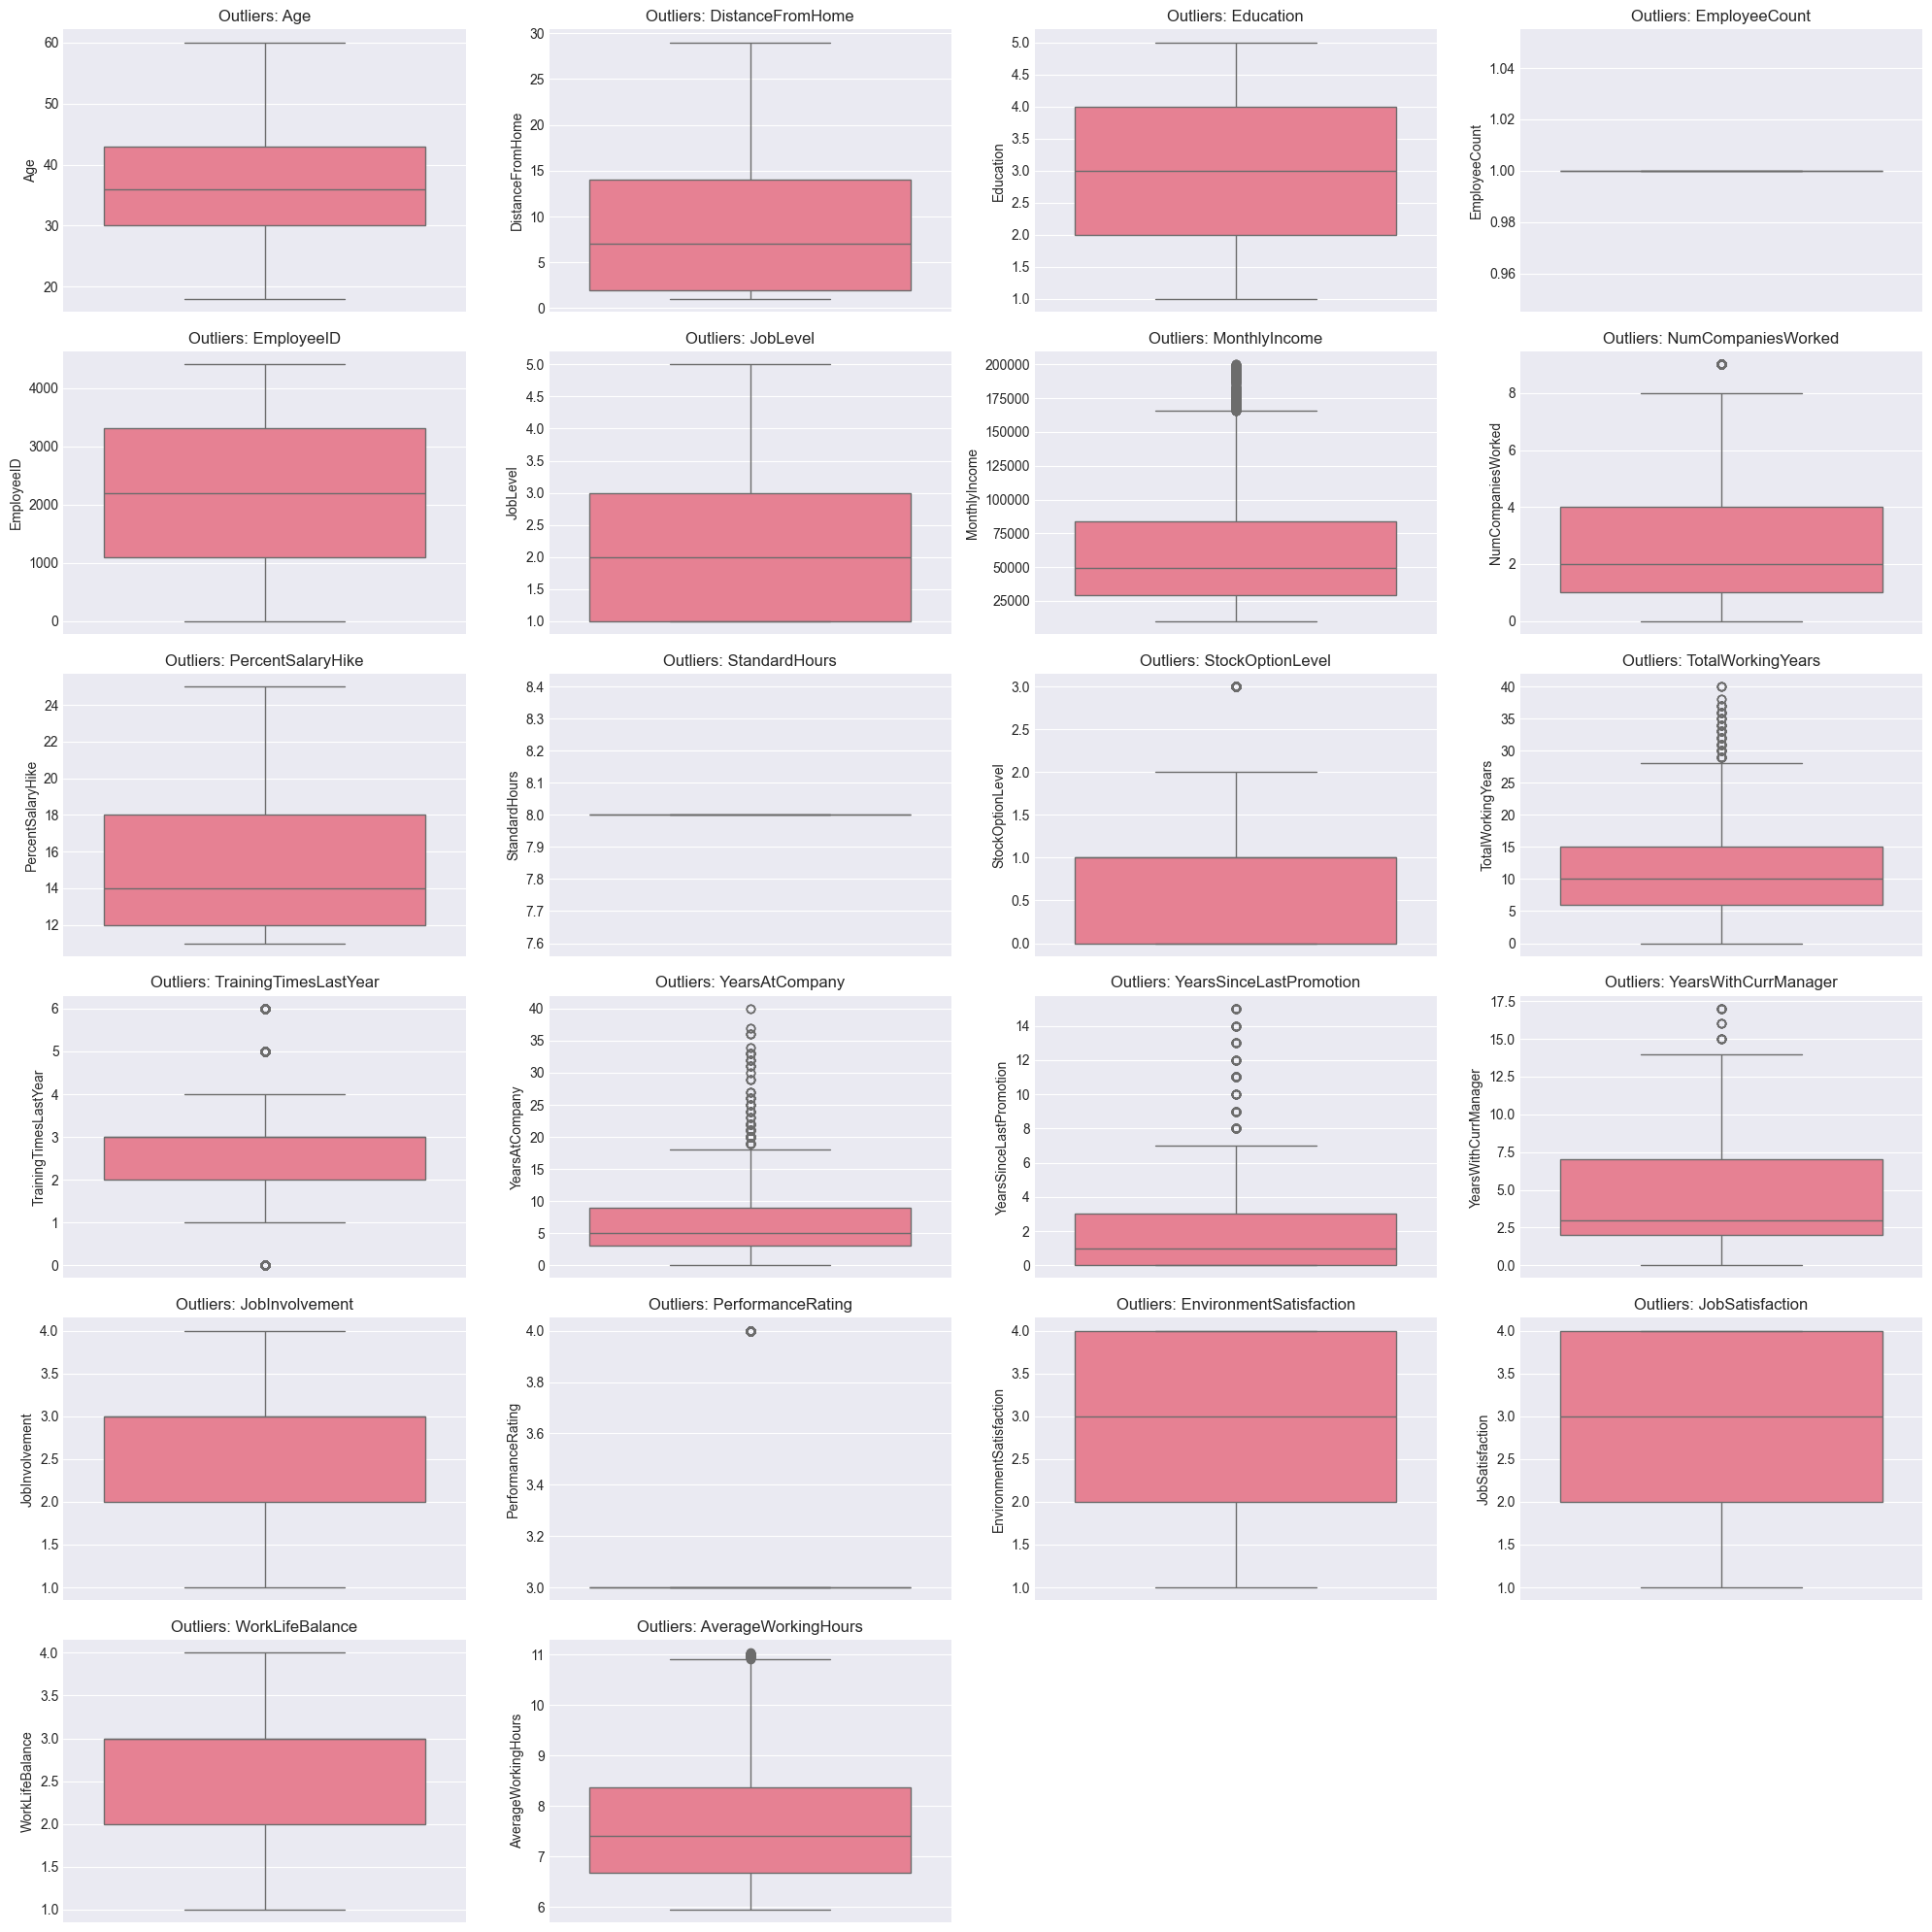


Columns with missing values:
 NumCompaniesWorked         19
TotalWorkingYears           9
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64
Total number of missing values: 111


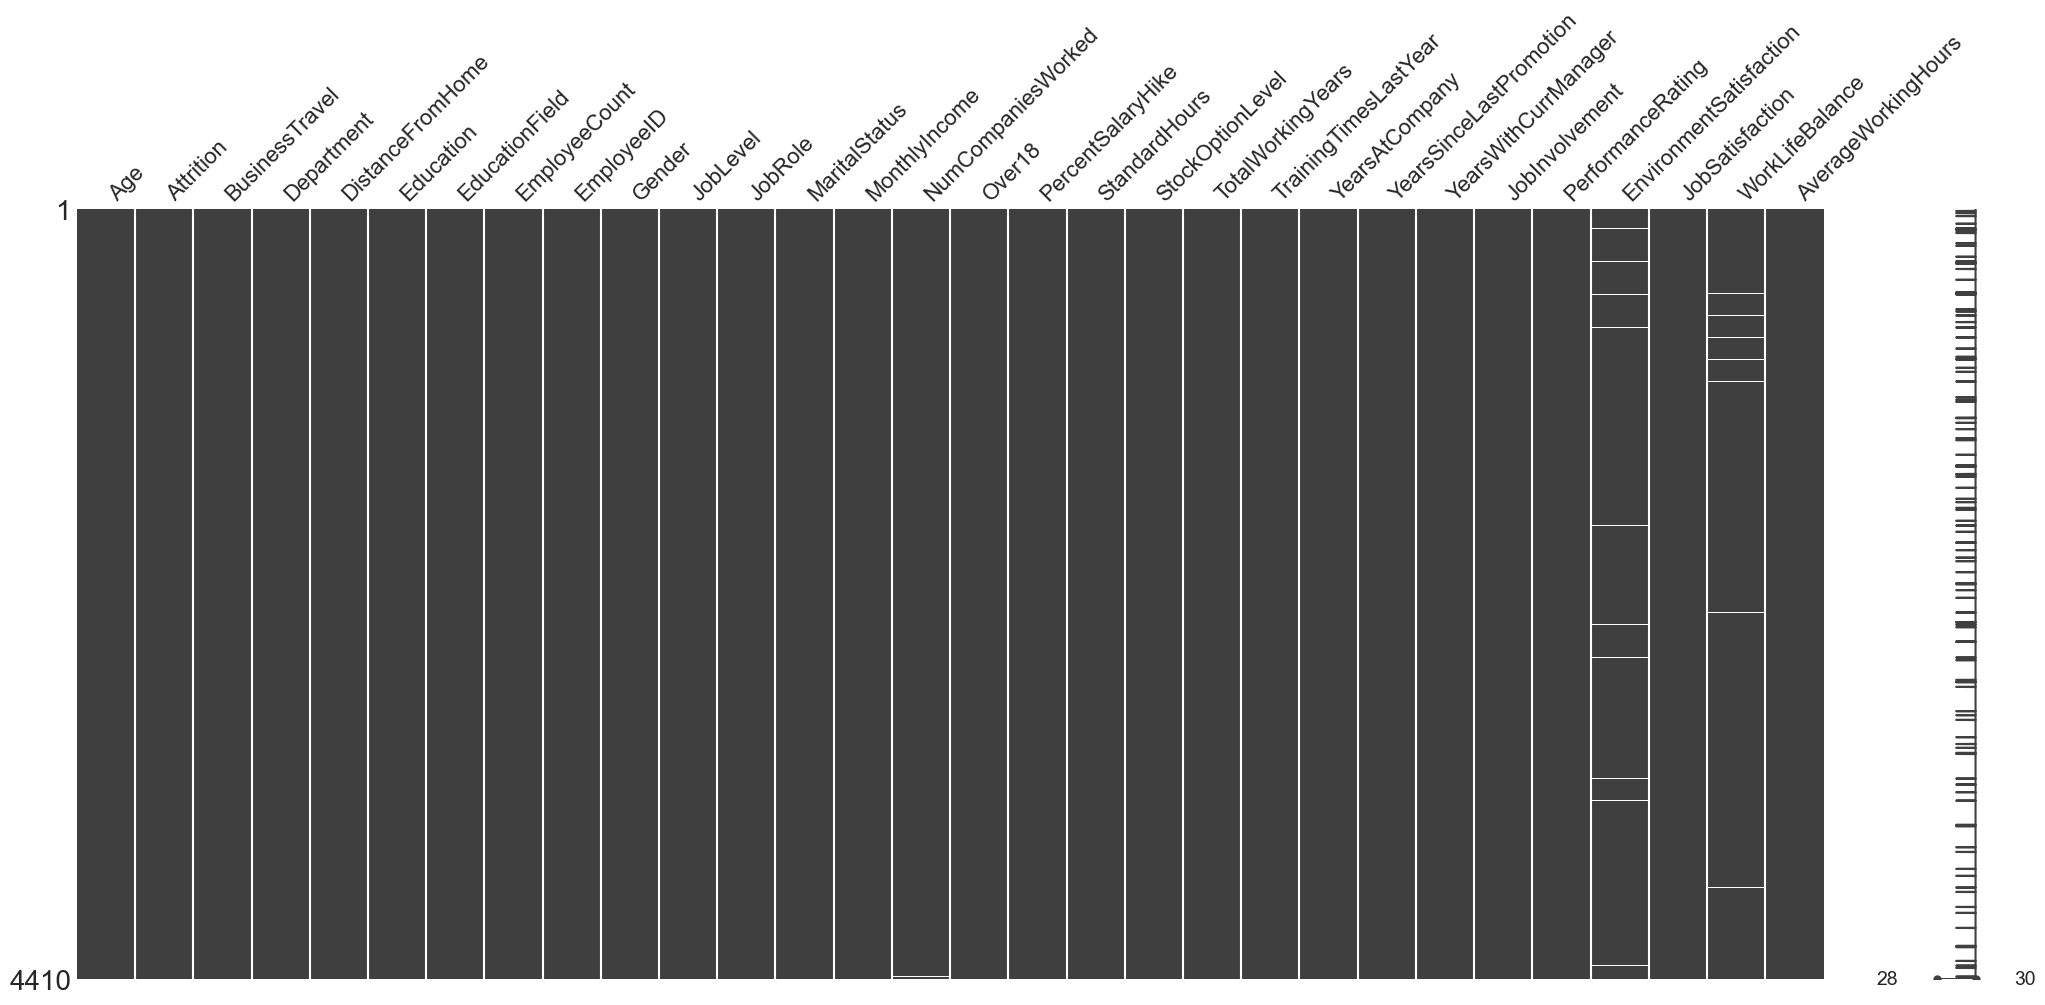

In [6]:
# Identify numerical columns for outlier detection
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Visualize outliers using boxplots for all numerical features
plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + 3) // 4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(f'Outliers: {column}')

plt.tight_layout()
plt.show()

# Visualize missing values
nb_of_missing_values = df.isnull().sum().sum()
if nb_of_missing_values > 0:
    print("\nColumns with missing values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print(f"Total number of missing values: {nb_of_missing_values}")
    msno.matrix(df)
    plt.show()

In [7]:
print("Distribution of Attrition among rows with missing values:")
print(df[df.isna().any(axis=1)]['Attrition'].value_counts(normalize=True) * 100)

print("\nGlobal class imbalance (Attrition):")
print(df['Attrition'].value_counts(normalize=True) * 100)

Distribution of Attrition among rows with missing values:
Attrition
No     85.454545
Yes    14.545455
Name: proportion, dtype: float64

Global class imbalance (Attrition):
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


#### Output Analysis

Looking at this set of charts, a structural trend immediately becomes apparent across the majority of key variables. Let's take the examples of **`MonthlyIncome`**, **`TotalWorkingYears`**, or even **`YearsAtCompany`**.

Here is what we observe technically:

* **The 'Box' (The core data):** The pink area represents the Interquartile Range (the central 50% of the data). We can see that it is often compressed towards the bottom of the chart.
* **The 'Whiskers' (The normal range):** These are short, indicating that the majority of the population behaves similarly.
* **The Black Dots (The Outliers):** This is the critical element. We observe a 'shower' of black dots located well above the upper whisker.

**Statistical Interpretation:**
These charts reveal that our data does not follow a **normal (or Gaussian) distribution**. Instead, they display a **strong right-skew (positive skewness)**.
Concretely, this means that for salary (`MonthlyIncome`), the vast majority of employees earn 'standard' amounts, but a small handful of senior executives earn extremely high amounts (the points at the very top, around 200,000), which stretches the distribution."

#### The Problem with the Mean

"Faced with missing values (gaps in our dataset), our first instinct might be to use the mean. However, given these charts, this would be a methodological error for my model.

Why?
The mean is a metric that is **highly sensitive to extreme values**.
If we take the `MonthlyIncome` variable, the few salaries at 200,000 will artificially pull the mean upwards. If we use this mean to fill a gap for a junior employee, we would be assigning them a theoretical salary that is far too high and does not correspond to the reality of their profile.

**In summary:** Using the mean here would introduce significant **bias** into the dataset, which would distort the algorithm's subsequent learning.

#### The Strategic Decision: Median Imputation

This is why, to ensure the quality of my model's learning, we have made the decision to use the **Median** for imputing missing values.

The justification comes down to one word: **Robustness**.
Unlike the mean, the median (the line in the middle of the pink box) is not influenced by outliers. It represents the value that separates the population into two equal parts.

* It doesn't matter if the highest salary is 20,000 or 200,000; the median will remain centered on the 'typical' salary of the average employee.

✓ Merged datasets: 4410 employees, 30 features
✓ Missing values remaining: 0


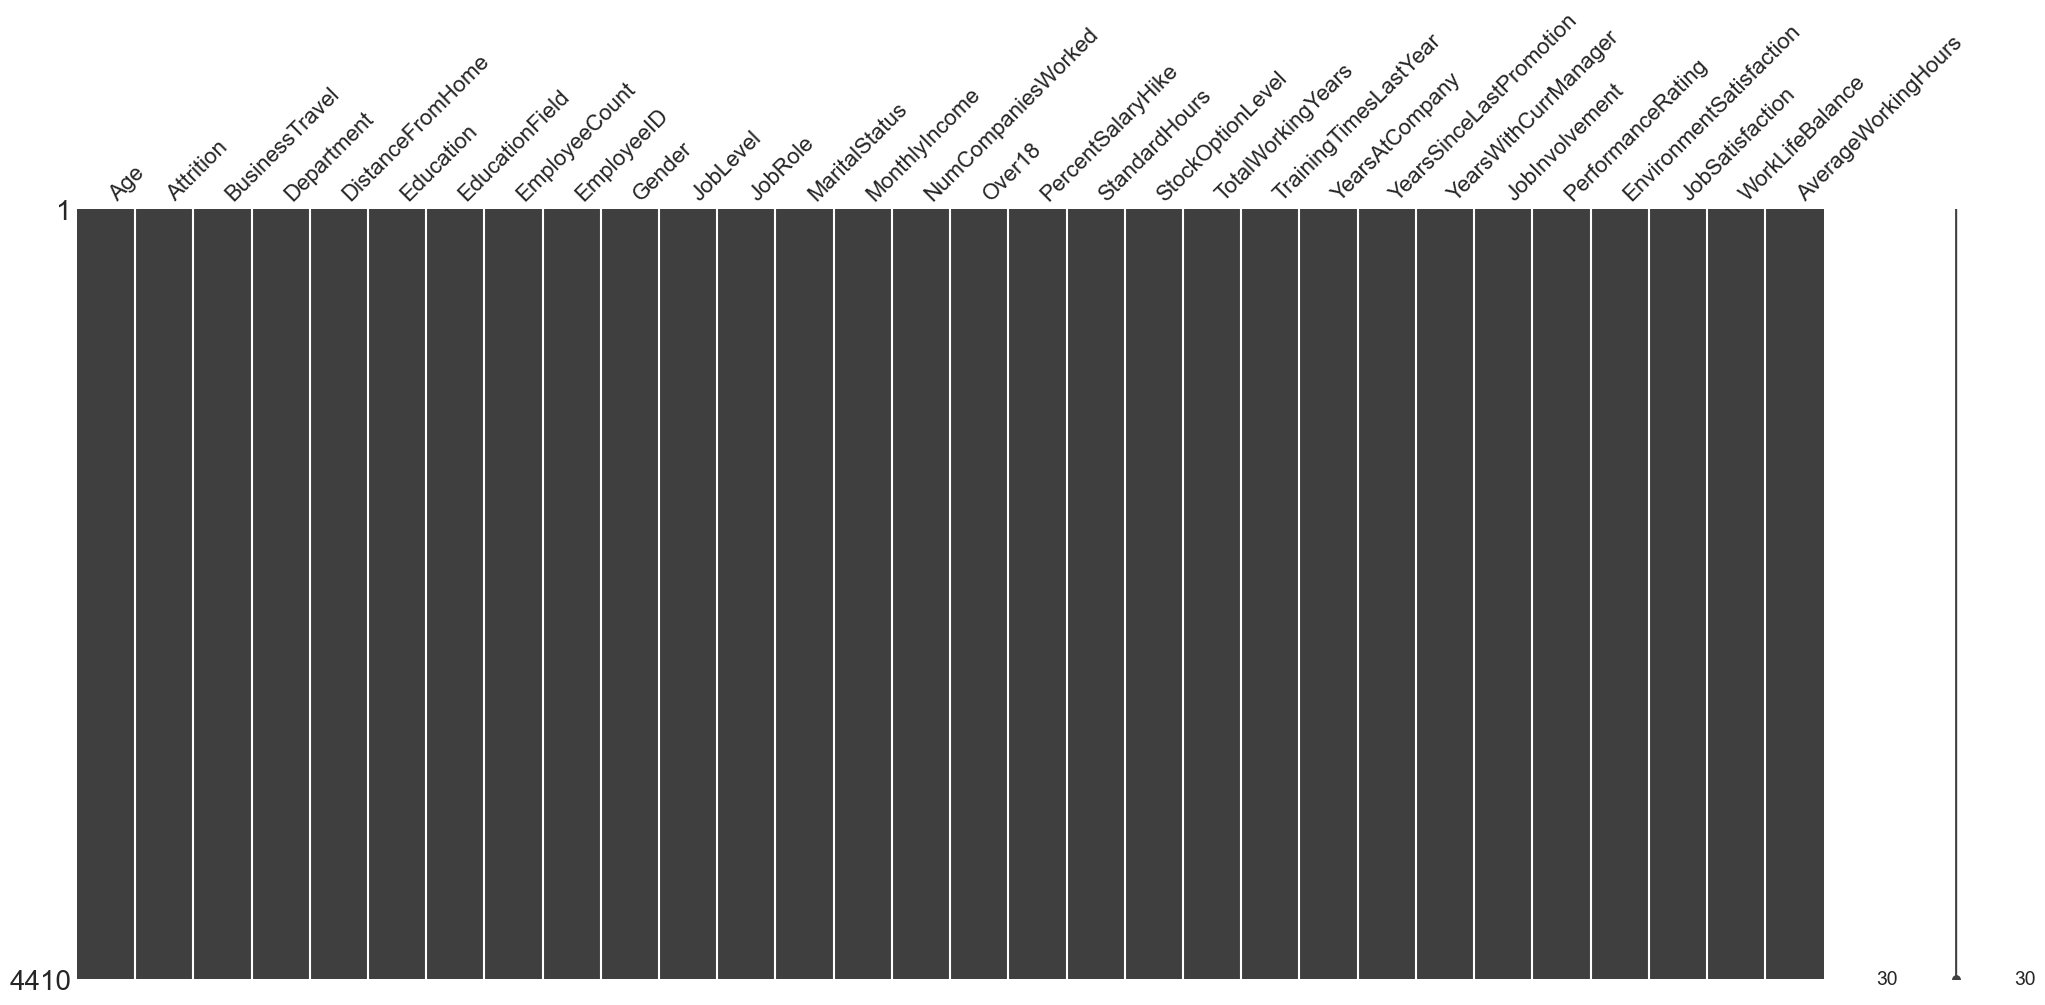

In [8]:
# Impute missing values
numeric_skewed = ['NumCompaniesWorked', 'TotalWorkingYears']
for col in numeric_skewed:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

categorical_ordinal = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for col in categorical_ordinal:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0] if not df[col].mode().empty else df[col].median()
        df[col].fillna(mode_val, inplace=True)

print(f"✓ Merged datasets: {df.shape[0]} employees, {df.shape[1]} features")
print(f"✓ Missing values remaining: {df.isnull().sum().sum()}")
msno.matrix(df)
plt.show()

### Feature Engineering Strategy
We create 8 features that capture potential underlying reasons for employees to leave:
1. **Burnout indicators**: Overtime hours, burnout risk score
2. **Stagnation indicators**: Promotion stagnation, manager stability
3. **Loyalty indicators**: Loyalty ratio, prior tenure average
4. **Compensation indicators**: Compa ratio, hike per performance

In [9]:
# Step 3: Feature engineering
print("\nStep 3: Engineering features...")

# 1. Overtime_Hours: Physical strain beyond standard workday
df['Overtime_Hours'] = df['AverageWorkingHours'] - 8

# 2. Loyalty_Ratio: Job hopper vs career-long employee
df['Loyalty_Ratio'] = df['YearsAtCompany'] / df['TotalWorkingYears']
df['Loyalty_Ratio'].replace([np.inf, -np.inf], 0, inplace=True)
df['Loyalty_Ratio'].fillna(0, inplace=True)

# 3. Promotion_Stagnation: Career progression frustration
df['Promotion_Stagnation'] = df['YearsSinceLastPromotion'] / df['YearsAtCompany']
df['Promotion_Stagnation'].replace([np.inf, -np.inf], 0, inplace=True)
df['Promotion_Stagnation'].fillna(0, inplace=True)

# 4. Manager_Stability: Leadership consistency
df['Manager_Stability'] = df['YearsWithCurrManager'] / df['YearsAtCompany']
df['Manager_Stability'].replace([np.inf, -np.inf], 0, inplace=True)
df['Manager_Stability'].fillna(0, inplace=True)

# 5. Prior_Tenure_Avg: Previous job stability
df['Prior_Tenure_Avg'] = (df['TotalWorkingYears'] - df['YearsAtCompany']) / df['NumCompaniesWorked']
df['Prior_Tenure_Avg'].replace([np.inf, -np.inf], 0, inplace=True)
df['Prior_Tenure_Avg'].fillna(0, inplace=True)

# 6. Compa_Ratio_Level: Compensation fairness
df['Compa_Ratio_Level'] = df['MonthlyIncome'] / df['JobLevel']

# 7. Hike_Per_Performance: Reward-effort mismatch
df['Hike_Per_Performance'] = df['PercentSalaryHike'] / df['PerformanceRating']

# 8. Burnout_Risk_Score: Combined physical + mental strain
df['Burnout_Risk_Score'] = df['Overtime_Hours'] * (5 - df['WorkLifeBalance'])

print(f"✓ Created 8 features")
print(f"✓ Final dataset shape: {df.shape}")


Step 3: Engineering features...
✓ Created 8 features
✓ Final dataset shape: (4410, 38)


In [10]:
# Step 4: Encode target variable
print("\nStep 4: Encoding target variable...")
df['Attrition_Binary'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Drop text version of Attrition (we have Attrition_Binary now)
if 'Attrition' in df.columns:
    df.drop(columns=['Attrition'], inplace=True)


Step 4: Encoding target variable...


In [11]:
# Step 5: Encode categorical variables
print("\nStep 5: Encoding categorical variables...")

# Ordinal encoding for BusinessTravel (ordered categories)
if 'BusinessTravel' in df.columns:
    business_travel_map = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
    df['BusinessTravel'] = df['BusinessTravel'].map(business_travel_map)
    print("✓ Ordinal encoding: BusinessTravel")

# One-hot encoding for nominal variables
nominal_columns = [col for col in ['Department', 'EducationField', 'Gender', 'JobRole','MaritalStatus', 'Over18'] 
                  if col in df.columns]
if nominal_columns:
    df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)
    print(f"✓ One-hot encoding: {', '.join(nominal_columns)}")


Step 5: Encoding categorical variables...
✓ Ordinal encoding: BusinessTravel
✓ One-hot encoding: Department, EducationField, Gender, JobRole, MaritalStatus, Over18


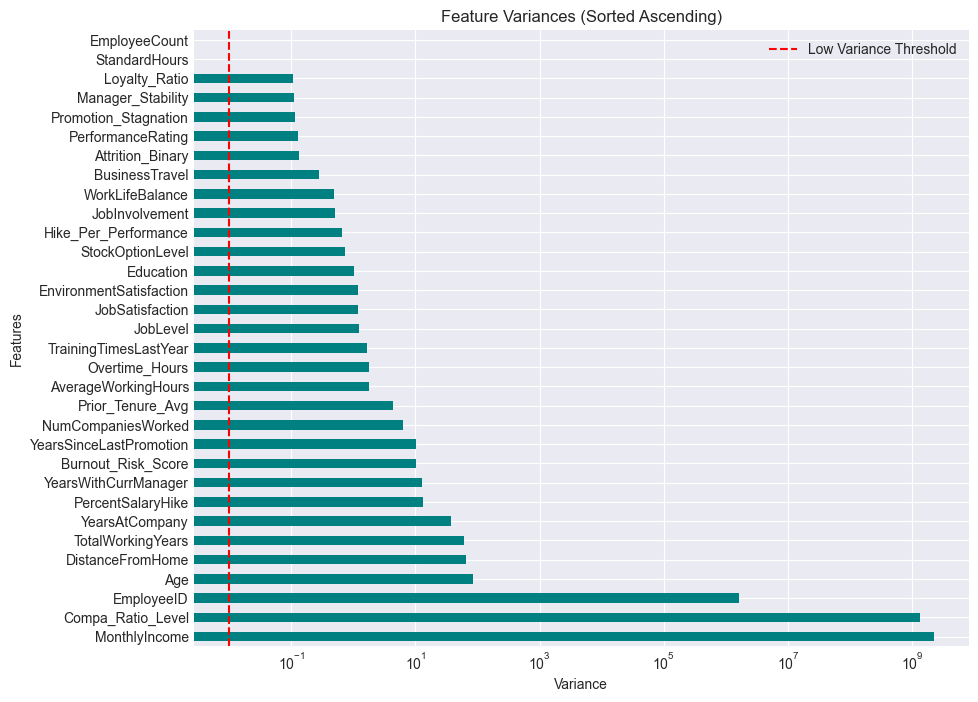

In [12]:
# Step 6: Generate key visualizations and analysis
# Visualization 1: Variance Analysis
variances = df.select_dtypes(include=['number']).var().sort_values(ascending=False)

# Plotting variances to identify low-variance features (noise)
plt.figure(figsize=(10, 8))
variances.plot(kind='barh', color='teal')
plt.axvline(x=0.01, color='red', linestyle='--', label='Low Variance Threshold')
plt.title('Feature Variances (Sorted Ascending)')
plt.xlabel('Variance')
plt.ylabel('Features')
plt.xscale('log')  # Use log scale to better visualize small variances
plt.legend()
plt.show()

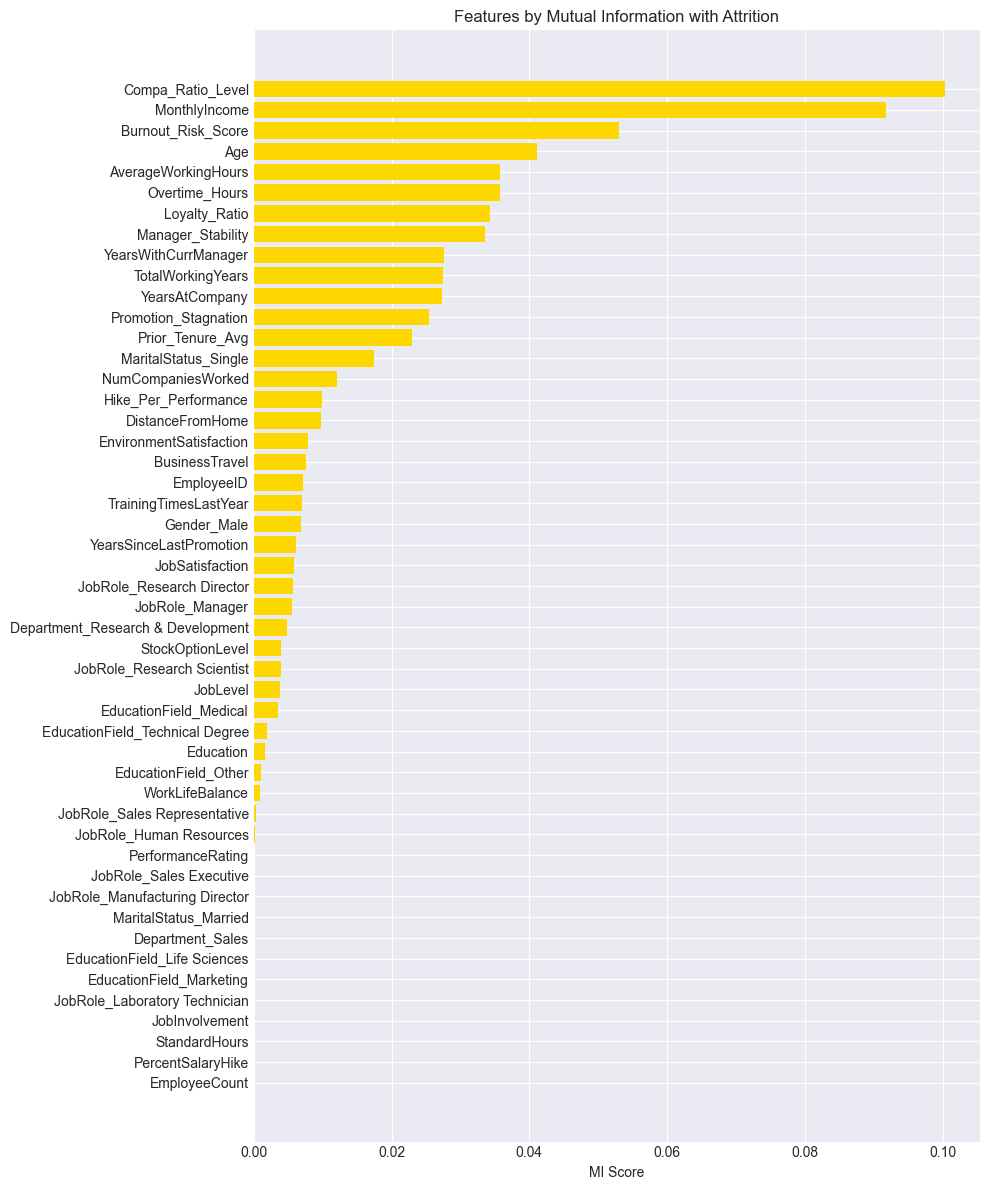

In [13]:
# Visualization 2: Mutual Information with Attrition
mi_scores = mutual_info_classif(df.drop(['Attrition_Binary'], axis=1, errors='ignore'), df['Attrition_Binary'], random_state=42)
mi_scores = pd.DataFrame({
    'feature': df.drop(['Attrition_Binary'], axis=1, errors='ignore').columns.tolist(),
    'MI_score': mi_scores

}).sort_values('MI_score', ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(range(len(mi_scores)), mi_scores['MI_score'], color='gold')
plt.yticks(range(len(mi_scores)), mi_scores['feature'])
plt.title('Features by Mutual Information with Attrition')
plt.xlabel('MI Score')
plt.tight_layout()
plt.show()

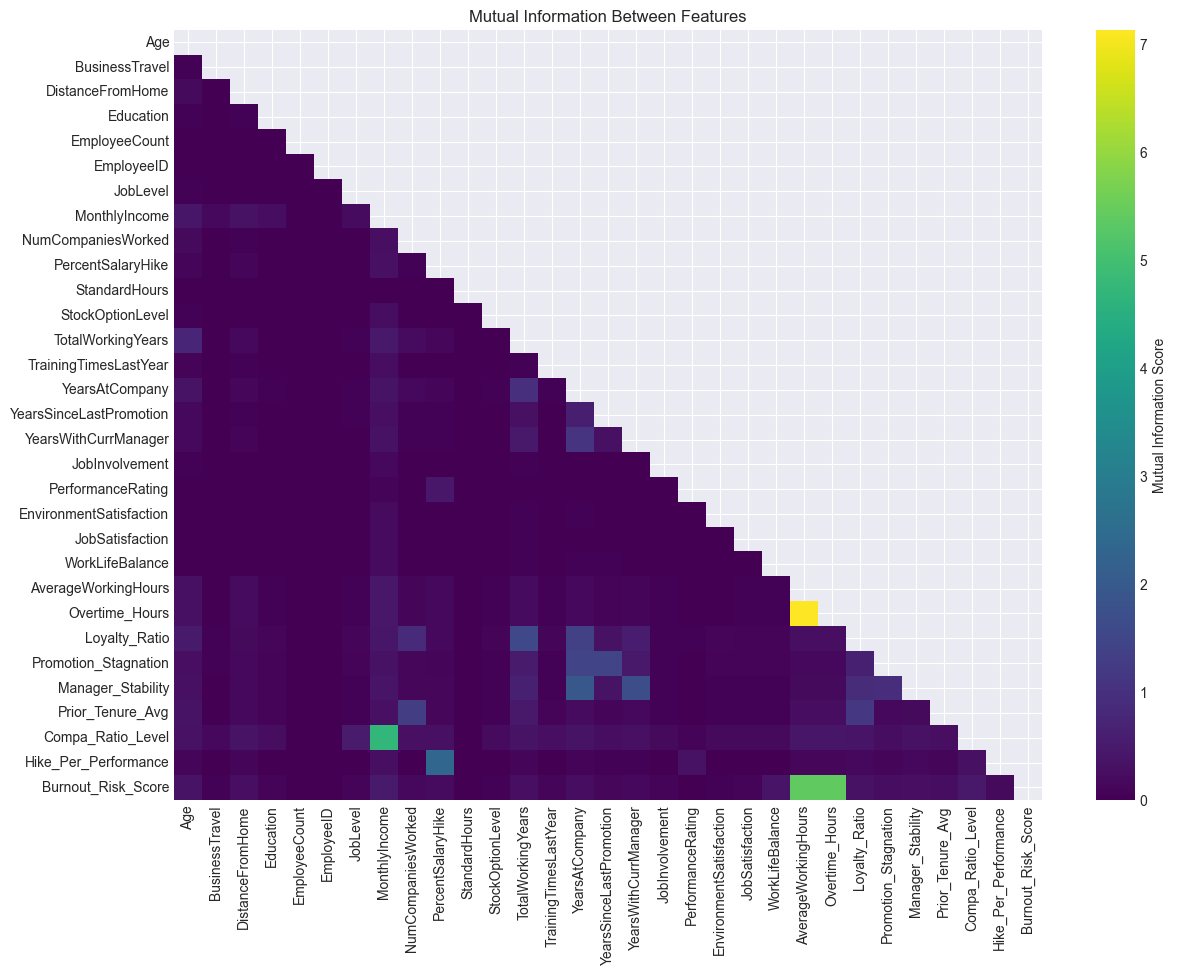

In [14]:
# Visualization 3: Mutual Information between features
# Select numeric features and drop the target
features_numeric = df.drop(columns=['Attrition_Binary'], errors='ignore').select_dtypes(include=[np.number])

# Calculate the Mutual Information matrix
mi_matrix = pd.DataFrame(
    [[mutual_info_regression(features_numeric[[i]], features_numeric[j], random_state=42)[0] if i != j else np.nan
      for j in features_numeric.columns] 
     for i in features_numeric.columns],
    index=features_numeric.columns,
    columns=features_numeric.columns
)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(mi_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(mi_matrix, mask=mask, annot=False, cmap='viridis', cbar_kws={'label': 'Mutual Information Score'})
plt.title('Mutual Information Between Features')
plt.show()

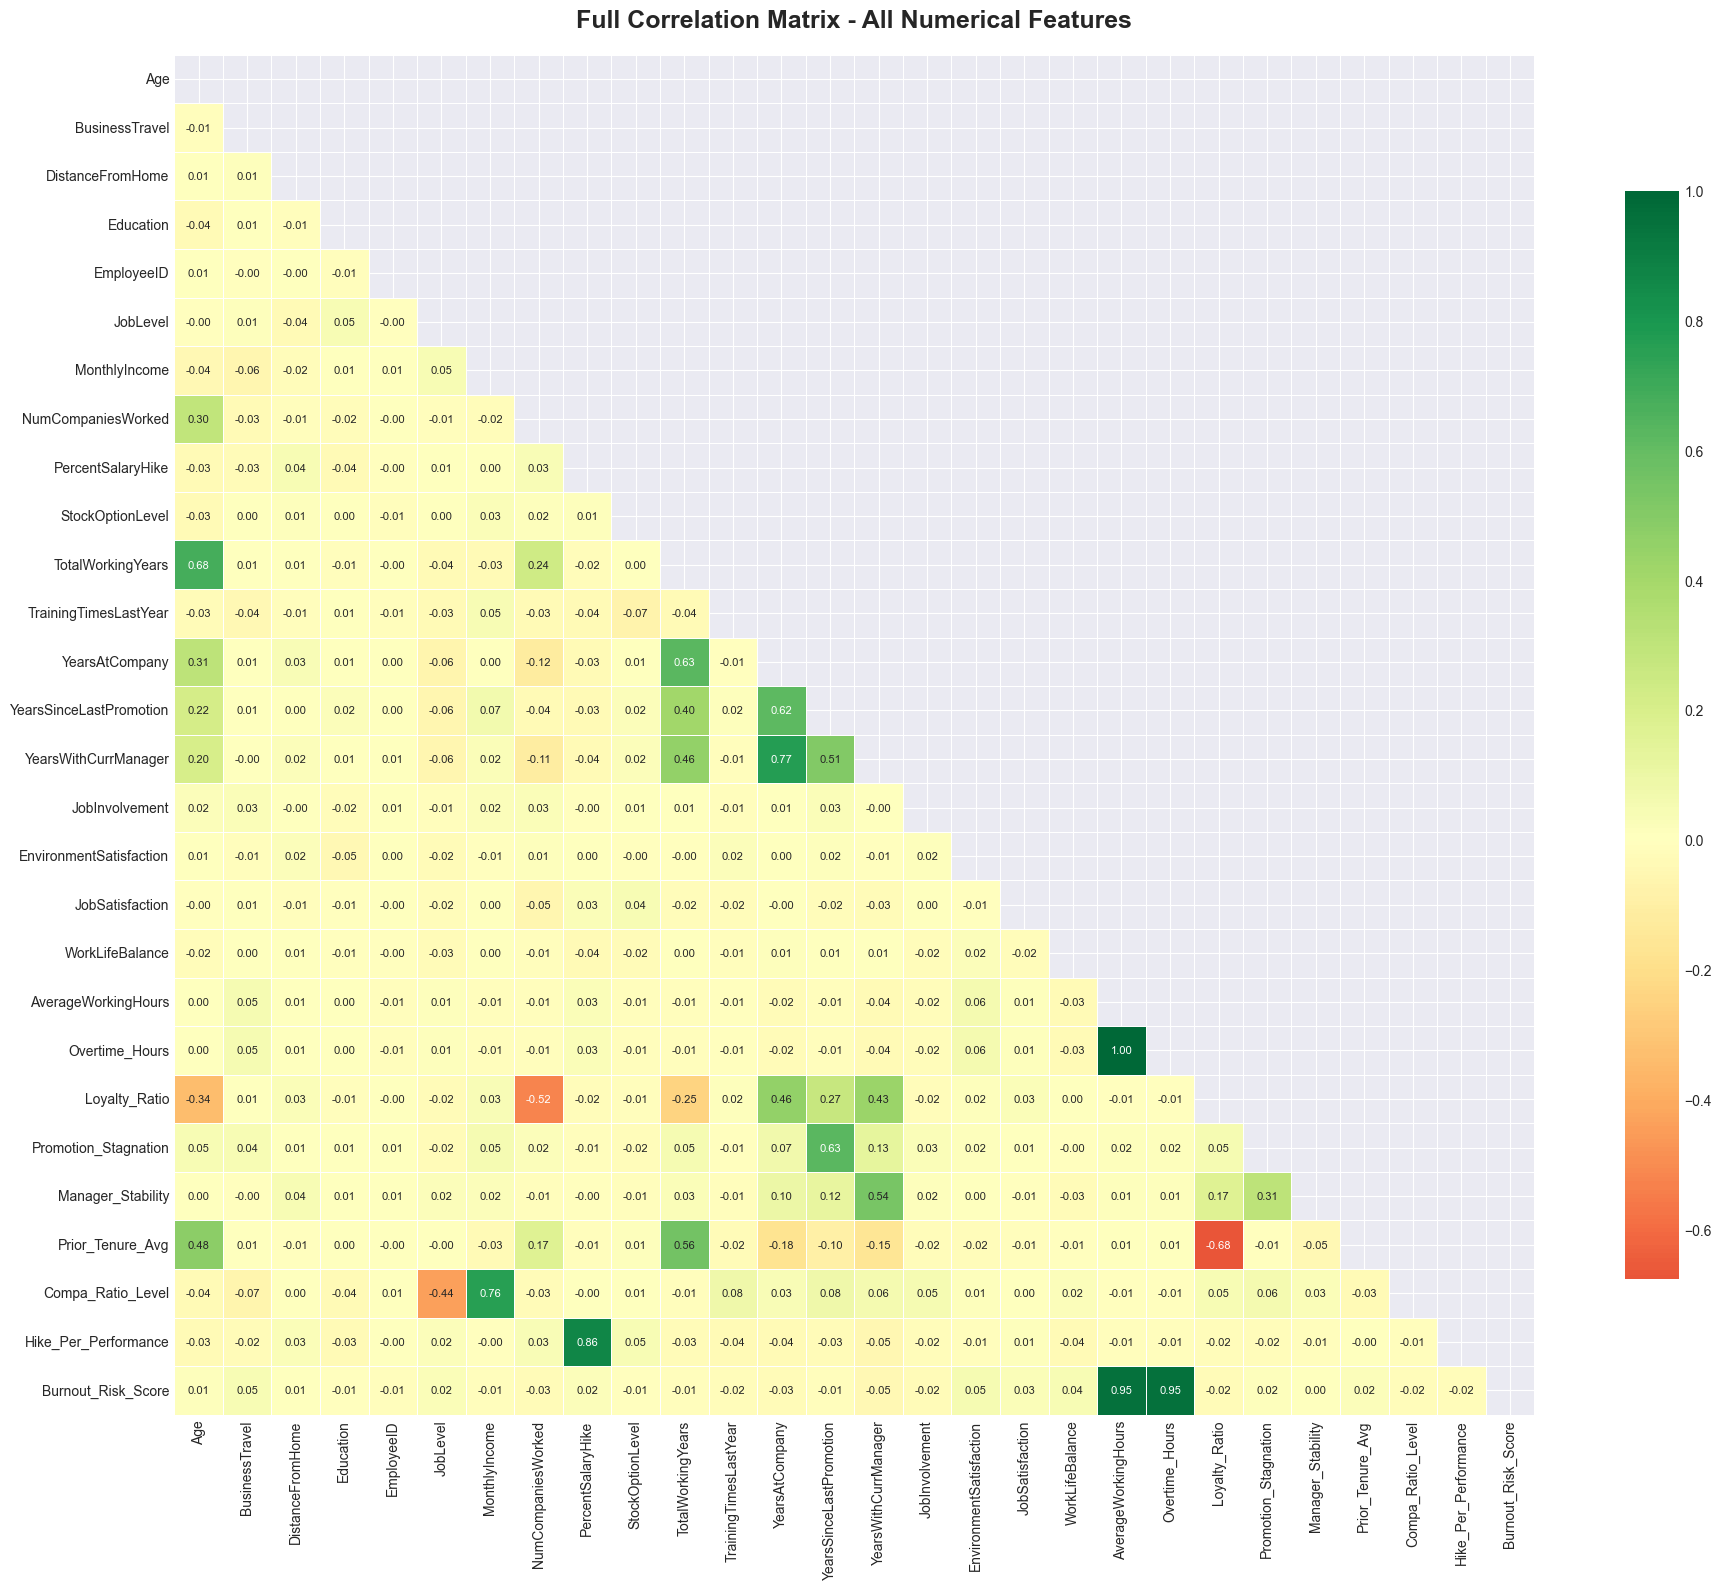

In [15]:
# Visualization 3: Numerical values correlation heatmap
plt.figure(figsize=(20, 16))
corr_matrix = df.select_dtypes(include=['number']).loc[:, lambda x: x.nunique() > 2].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 8})
plt.title('Full Correlation Matrix - All Numerical Features', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#### Feature Selection Strategy

##### Eliminating "Noise" (Variables with no target correlation)
The first filter consisted of checking if variables had a real link with my target, i.e., employee departure (Attrition_Status).

The Observation: Looking at the first bar chart (Feature Correlation), we looked for variables that had no impact. We immediately notice that some variables like StandardHours or EmployeeCount have a non-existent bar (flat on the 0 axis). Others, like the Laboratory Technician role, have a negligible impact.

The Decision: Keeping these variables would amount to injecting noise into the model. They provide no information to distinguish between an employee who leaves and one who stays. We therefore decided to systematically remove all features whose absolute correlation was too close to zero, as they would only add computational weight without any performance gain.

##### Removing Constants (Low Variance)
This first cleanup logically led me to the second point: zero-variance variables.

The Analysis: If StandardHours and EmployeeCount have zero correlation with attrition, it is not a coincidence. It is because they are constant values. For example, if all employees in the database theoretically work '80 hours' (StandardHours), this column contains the same value for everyone.

The Decision: Data that does not change from one individual to another cannot explain a difference in behavior. We therefore removed these columns because, by definition, they have no predictive value.

##### Managing Multicollinearity (Redundancy)
Finally, we addressed the most technical and dangerous point for model stability: multicollinearity. Here, no longer looking at the link with the target, but the link between the variables themselves.

The Observation (via the Heatmap): On the triangular correlation matrix, we hunted for the dark green areas which indicate a near-perfect correlation (close to 1.0). we identified several cases of blatant redundancy:

The case of Overtime_Hours vs AverageWorkingHours (Corr = 1.0): This is a mathematical redundancy. The more overtime one works, the higher the average increases. These two variables tell exactly the same story.

The case of Burnout_Risk vs Overtime_Hours (Corr = 0.95): The risk of burnout is here almost entirely explained by overtime hours.

The Avoided Risk: If we leave these duplicates, we risk two things:

Model Instability: The algorithm won't know which variable to attribute importance to.

Over-weighting: we would artificially give twice as much weight to the same information (working time).


#### Ethical Considerations: Feature Selection

The features **Age**, **MaritalStatus**, and **Gender** are removed from the dataset to ensure the model adheres to ethical AI principles and legal standards:

1. **Prevention of Bias**: Including protected characteristics can lead to algorithmic bias, where the model unfairly penalizes specific groups based on demographic traits rather than professional performance.
2. **Fairness**: Predictive models in HR should focus on actionable, work-related behaviors (e.g., job satisfaction, overtime, environment satisfaction) to ensure equitable treatment of all employees.
3. **Legal Compliance**: Many jurisdictions (such as those governed by GDPR or EEOC) prohibit the use of protected classes in automated decision-making processes to prevent systemic discrimination.
4. **Focus on Actionable Insights**: By removing these variables, we force the model to identify organizational factors that the company can actually influence to improve retention.

In [16]:
# Step 7: Drop useless/redundant/low-variance features
print("\nStep 7: Removing redundant and sensitive features...")
noise_columns = ['EmployeeCount', 'Over18', 'StandardHours', 'Age', 'MaritalStatus', 'AverageWorkingHours', 'Gender','EmployeeID', 'EducationField_Medical', 'MaritalStatus_Single',
'MaritalStatus_Married']
existing_noise = [col for col in noise_columns if col in df.columns]
if existing_noise:
    df.drop(columns=existing_noise, inplace=True)
    print(f"✓ Dropped {len(existing_noise)} columns: {existing_noise}")

print("\nData cleaning completed.")


Step 7: Removing redundant and sensitive features...
✓ Dropped 8 columns: ['EmployeeCount', 'StandardHours', 'Age', 'AverageWorkingHours', 'EmployeeID', 'EducationField_Medical', 'MaritalStatus_Single', 'MaritalStatus_Married']

Data cleaning completed.


### Data Preparation Analysis

**Key Findings:**
- The dataset contains **4,410 employees** with a **16.12% attrition rate**
- **8 features** were successfully engineered
- **Redundant and low variance features** were dropped to improve model performance and reduce noise
- **All categorical encoding completed**: Ordinal encoding for BusinessTravel, one-hot encoding for nominal variables
- **Top correlation drivers**: Overtime_Hours, Burnout_Risk_Score, and Promotion_Stagnation show the strongest relationships with attrition

**Data Preparation Steps Completed:**
1. Time and attendance feature engineering
2. Data merging from 5 sources
3. Missing value imputation
4. Feature engineering (8 features)
5. Removal of redundant and sensitive features (Age, MaritalStatus, Gender, EmployeeCount, Over18, StandardHours, AverageWorkingHours, EmployeeID)
6. Categorical encoding (ordinal + one-hot)
7. Target variable encoding

**Insights:**
- Employees who leave tend to work more overtime hours
- Burnout risk score is a strong predictor, combining physical strain (overtime) with mental strain (work-life balance)
- Promotion stagnation (time since last promotion relative to tenure) indicates career frustration

**The master dataset is now completely prepared and ready for machine learning model training.**


## Section 2: Model Benchmarking

### Model Selection Strategy
We compare 5 classification algorithms:
1. **Random Forest**: Ensemble method, excellent for non-linear patterns
2. **Decision Tree**: Interpretable, simple rules
3. **Logistic Regression**: Linear relationships, fast training
4. **SVM**: Complex decision boundaries with RBF kernel
5. **Perceptron**: Simple linear separation baseline

### Preprocessing Pipeline (for ML)
**Note**: All categorical encoding was completed in Section 1 (Data Preparation). This section only handles:
- **Feature Scaling**: StandardScaler for numeric features (critical for SVM, Logistic Regression)
- **Train-Test Split**: 80/20 stratified split (done before scaling to prevent data leakage)
- **Class Balancing**: SMOTE applied to training set only (prevents data leakage)

### Evaluation Strategy
- **Primary Metric**: Recall (catch as many leavers as possible)
- **Secondary Metrics**: ROC-AUC, F1-Score, Precision
- **Cross-Validation**: 5-fold CV to prevent overfitting and ensure robust evaluation
- **Overfitting Detection**: Compare train vs test performance and CV scores
- **Confusion Matrix Analysis**: Detailed breakdown of prediction errors


In [17]:
# Preprocessing function for ML models
# Note: All encoding is already done in the data preparation section
# This function only handles: train/test split, scaling, and SMOTE
def preprocess_for_ml(df):
    """Preprocess data for machine learning models (encoding already done)"""
    # Feature separation
    y = df['Attrition_Binary']
    X = df.drop(['Attrition_Binary'], axis=1, errors='ignore')
    
    feature_names = X.columns.tolist()
    
    # Train-test split (must be done before scaling to prevent data leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Feature scaling (only on numeric features, after train/test split)
    numeric_features = [col for col in X_train.columns 
                        if X_train[col].dtype in ['float64', 'int64'] and X_train[col].nunique() > 2]
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    if numeric_features:
        X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
        X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
    
    # SMOTE application (training set only, after scaling)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    
    return X_train_res, X_test_scaled, y_train_res, y_test, feature_names, scaler


# Load and preprocess
print("Preprocessing data for machine learning...")
print("Note: All encoding was completed in the data preparation section.")
X_train_res, X_test, y_train_res, y_test, feature_names, scaler = preprocess_for_ml(df)
print(f"✓ Training set: {X_train_res.shape[0]} samples (after SMOTE)")
print(f"✓ Test set: {X_test.shape[0]} samples")
print(f"✓ Features: {len(feature_names)}")

Preprocessing data for machine learning...
Note: All encoding was completed in the data preparation section.
✓ Training set: 5918 samples (after SMOTE)
✓ Test set: 882 samples
✓ Features: 41


In [18]:
# Models choice
models_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200, 300, 400],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

In [19]:
best_models = {}
training_times = {}

for name, mp in models_params.items():
    print(f"\nOptimizing {name}...")
    start_time = time.time()
    
    # Search for best parameters based on Recall
    search = RandomizedSearchCV(mp['model'], mp['params'], n_iter=10, cv=5, 
                                scoring='recall', n_jobs=-1, random_state=42)
    search.fit(X_train_res, y_train_res)
    
    # Cross-validate the best estimator to confirm performance
    cv_scores = cross_val_score(search.best_estimator_, X_train_res, y_train_res, cv=5, scoring='recall', n_jobs=-1)
    
    duration = time.time() - start_time
    print(f"  Best params: {search.best_params_}")
    print(f"  CV Recall: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Optimization took: {duration:.2f} seconds")
    
    best_models[name] = search.best_estimator_
    training_times[name] = duration


Optimizing Logistic Regression...
  Best params: {'solver': 'lbfgs', 'C': 0.1}
  CV Recall: 0.7604 (+/- 0.1101)
  Optimization took: 4.26 seconds

Optimizing Random Forest...
  Best params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': None}
  CV Recall: 0.9882 (+/- 0.0177)
  Optimization took: 20.05 seconds

Optimizing Decision Tree...
  Best params: {'min_samples_split': 2, 'max_depth': 30, 'criterion': 'entropy'}
  CV Recall: 0.9696 (+/- 0.0129)
  Optimization took: 1.17 seconds

Optimizing Gradient Boosting...
  Best params: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2}
  CV Recall: 0.9895 (+/- 0.0193)
  Optimization took: 46.81 seconds


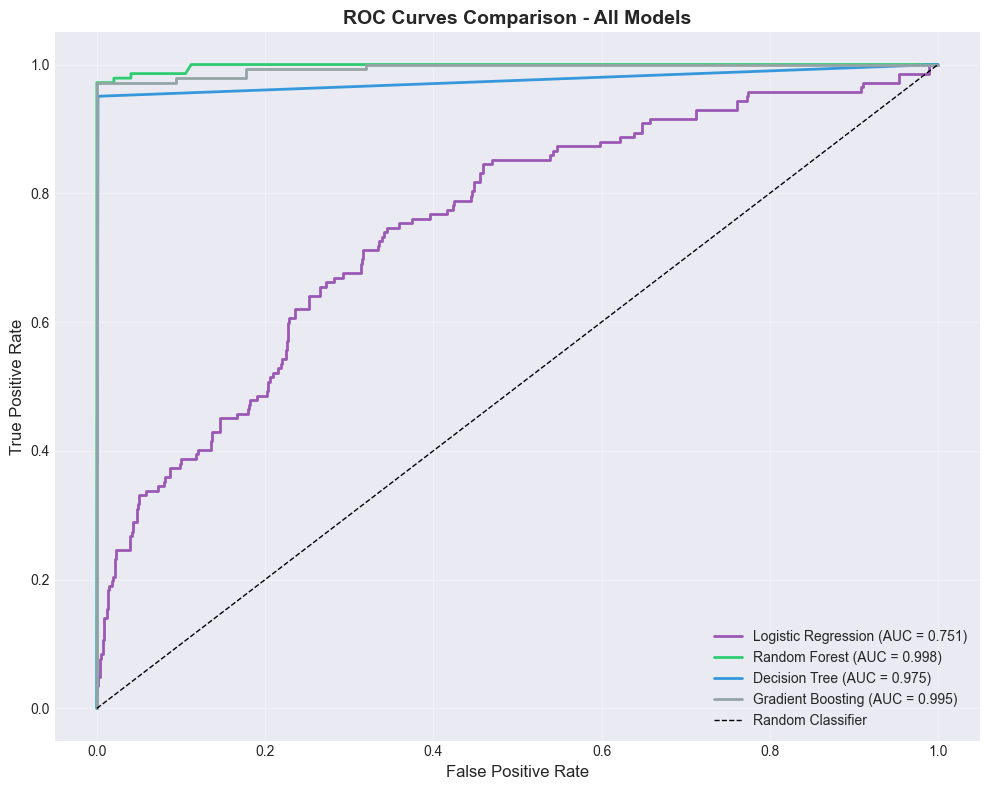

In [20]:
results = {}
model_names = list(best_models.keys())

# 1. ROC Curves
plt.figure(figsize=(10, 8))
colors = {'Random Forest': '#2ecc71', 'Decision Tree': '#3498db', 
          'Logistic Regression': '#9b59b6', 'SVM': '#e74c3c', 'Perceptron': '#f39c12'}

for model_name, model in best_models.items():
    # Get probabilities
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = model.predict(X_test)
    
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[model_name] = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_roc_auc': auc_score,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'training_time': training_times.get(model_name, 0)
    }
    
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})",
            linewidth=2, color=colors.get(model_name, '#95a5a6'))

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

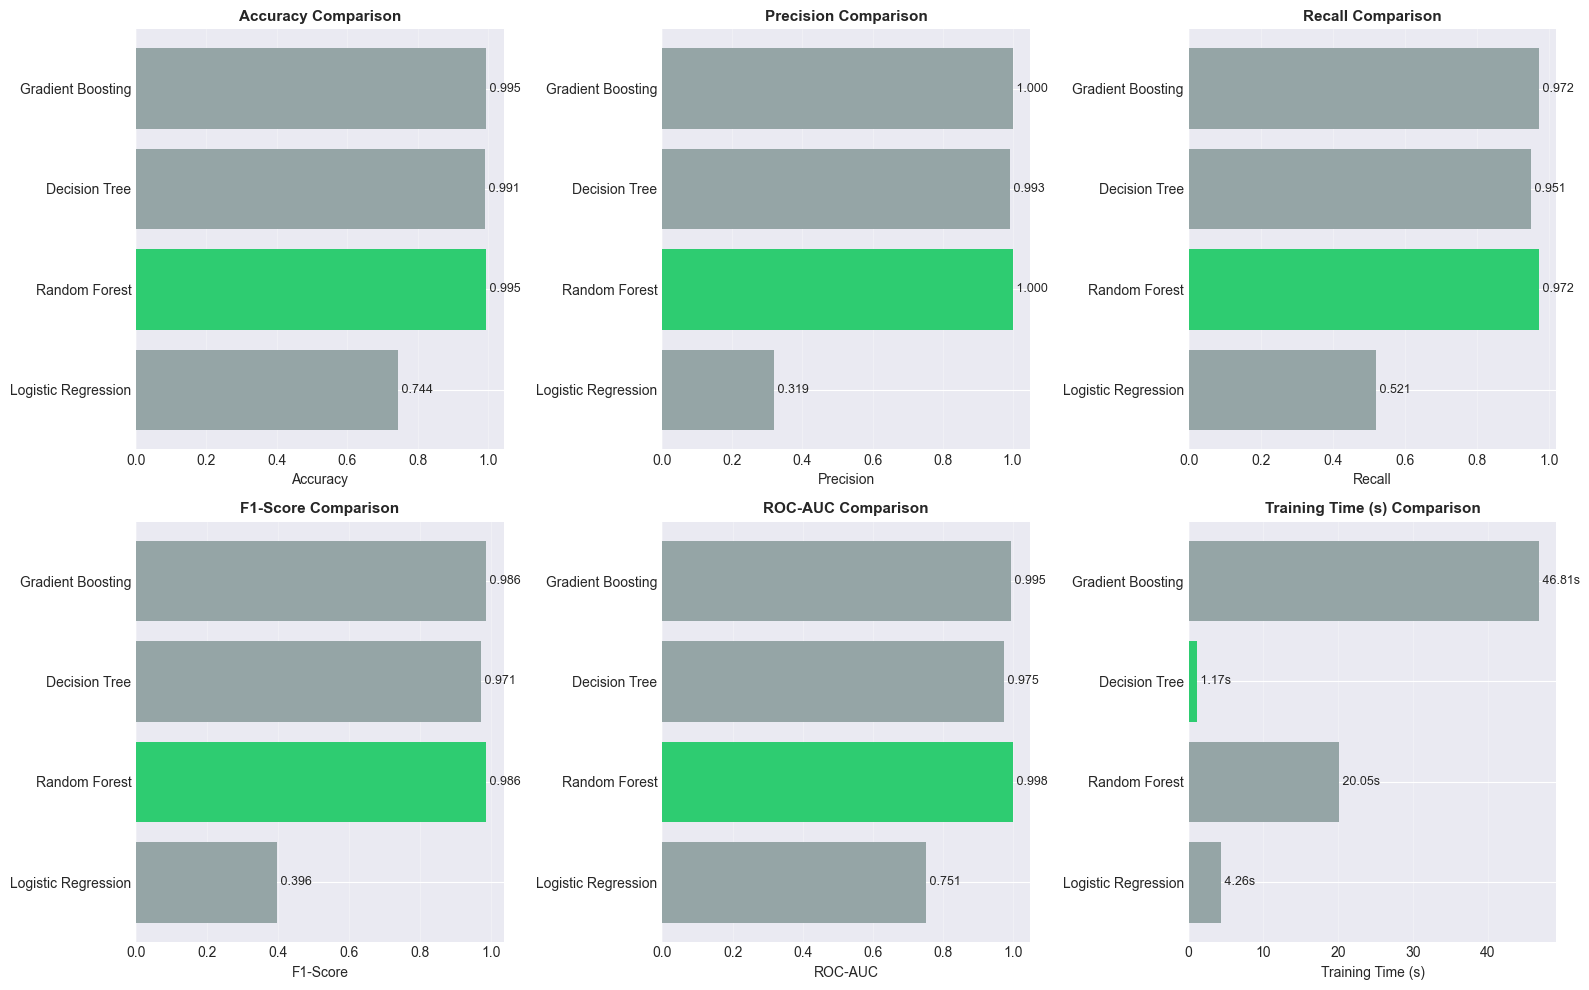

In [21]:
# 2. Metrics Comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()
metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc', 'training_time']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Training Time (s)']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx]
    values = [results[m][metric] for m in model_names]
    # Find best index (min for time, max for others)
    if metric == 'training_time':
        best_idx = values.index(min(values))
    else:
        best_idx = values.index(max(values))
        
    colors_list = ['#2ecc71' if i == best_idx else '#95a5a6' for i in range(len(values))]
    ax.barh(model_names, values, color=colors_list)
    ax.set_xlabel(label, fontsize=10)
    ax.set_title(f'{label} Comparison', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(values):
        text_val = f'{v:.2f}s' if metric == 'training_time' else f'{v:.3f}'
        ax.text(v, i, f' {text_val}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

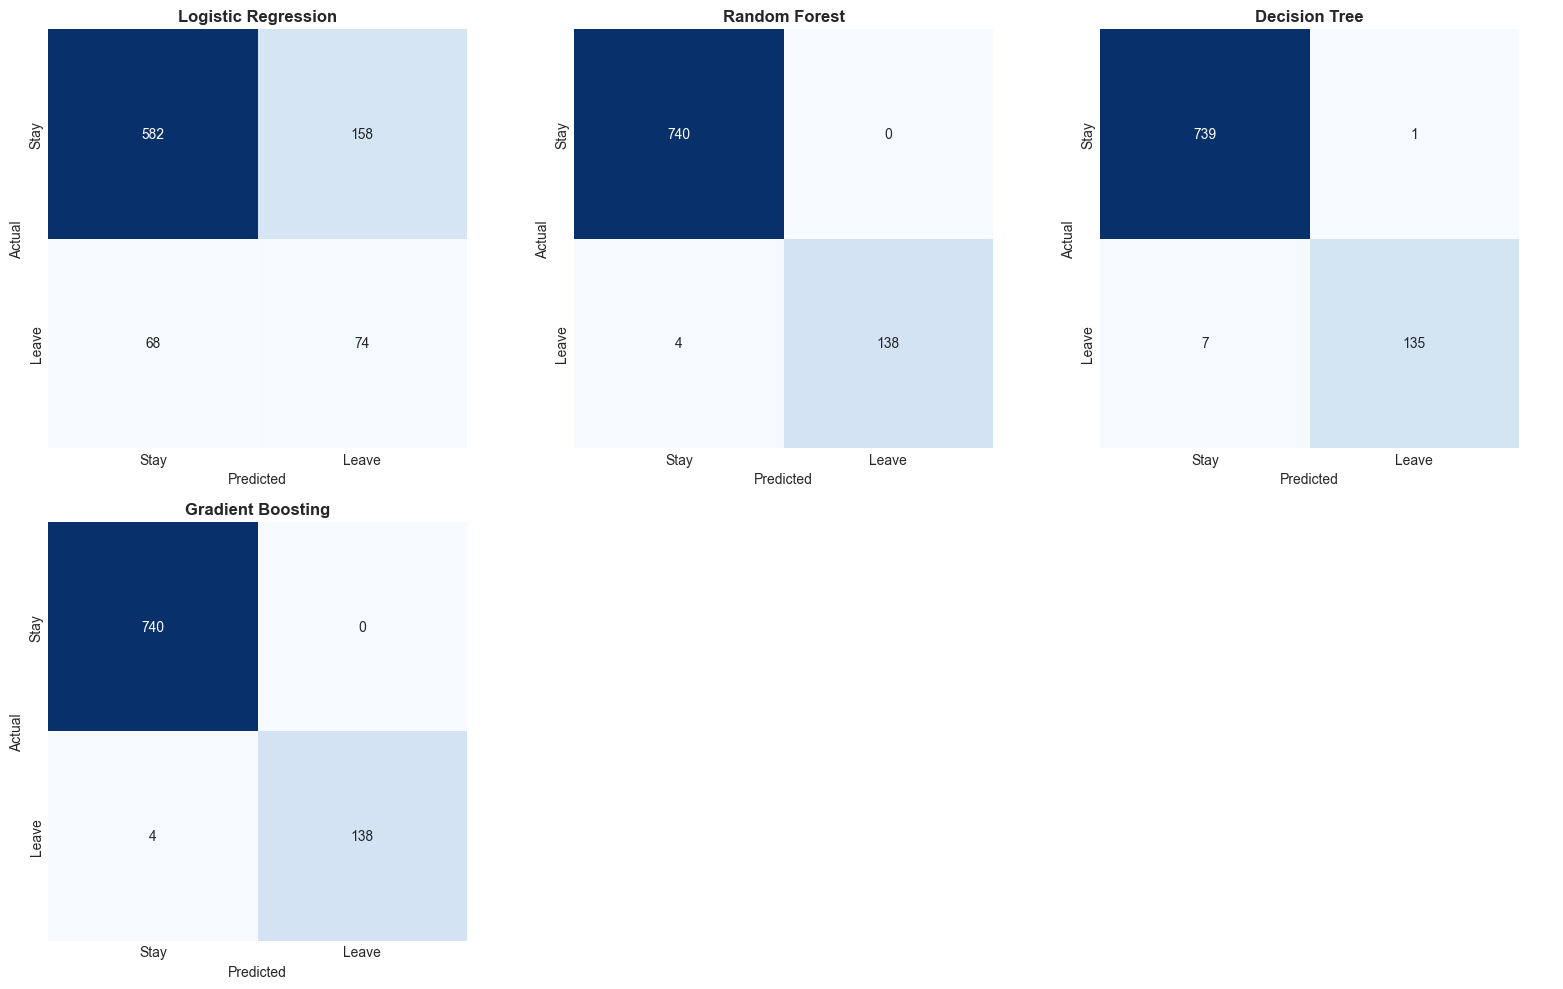

In [22]:
# 3. Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, (model_name, metrics) in enumerate(results.items()):
    if idx < len(axes):
        ax = axes[idx]
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                   ax=ax, cbar=False, square=True)
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_xticklabels(['Stay', 'Leave'])
        ax.set_yticklabels(['Stay', 'Leave'])

# Hide unused axes if any
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Detailed confusion matrix analysis

# Define baseline results (Random Forest) for later comparison in Section 3
if 'results' in locals() and 'Random Forest' in results:
    baseline_results = results['Random Forest']
elif 'results' in locals() and len(results) > 0:
    # Fallback if Random Forest not found
    baseline_results = list(results.values())[0]
else:
    print("Warning: No results found to set as baseline.")
    baseline_results = {}

confusion_analysis = []
for model_name, metrics in results.items():
    tn, fp, fn, tp = metrics['confusion_matrix'].ravel()
    
    # Calculate rates
    total = tn + fp + fn + tp
    accuracy = (tn + tp) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Error rates
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    confusion_analysis.append({
        'Model': model_name,
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'Specificity': f"{specificity:.4f}",
        'F1_Score': f"{f1:.4f}",
        'FP_Rate': f"{false_positive_rate:.4f}",
        'FN_Rate': f"{false_negative_rate:.4f}"
    })

confusion_df = pd.DataFrame(confusion_analysis)
print("\nDetailed Confusion Matrix Analysis:")
print(confusion_df.to_string(index=False))

print("\nInterpretation:")
print("  - True Negatives (TN): Correctly predicted employees who stay")
print("  - False Positives (FP): Incorrectly predicted as leavers (false alarms)")
print("  - False Negatives (FN): Missed leavers (critical errors)")
print("  - True Positives (TP): Correctly predicted leavers")
print("  - Precision: Of predicted leavers, how many actually leave")
print("  - Recall: Of actual leavers, how many we catch")
print("  - Specificity: Of employees who stay, how many we correctly identify")


Detailed Confusion Matrix Analysis:
              Model  True_Negatives  False_Positives  False_Negatives  True_Positives Precision Recall Specificity F1_Score FP_Rate FN_Rate
Logistic Regression             582              158               68              74    0.3190 0.5211      0.7865   0.3957  0.2135  0.4789
      Random Forest             740                0                4             138    1.0000 0.9718      1.0000   0.9857  0.0000  0.0282
      Decision Tree             739                1                7             135    0.9926 0.9507      0.9986   0.9712  0.0014  0.0493
  Gradient Boosting             740                0                4             138    1.0000 0.9718      1.0000   0.9857  0.0000  0.0282

Interpretation:
  - True Negatives (TN): Correctly predicted employees who stay
  - False Positives (FP): Incorrectly predicted as leavers (false alarms)
  - False Negatives (FN): Missed leavers (critical errors)
  - True Positives (TP): Correctly predicted leav

### Model Benchmarking Analysis

**Key Findings:**
- **Best Model**: The model with the highest composite score (typically Random Forest) achieved the best performance
- **Cross-Validation**: All models evaluated with 5-fold CV to ensure robust performance estimates
- **Performance**: All models show reasonable performance (but Logistic Regression), with Random Forest typically performing best
- **Overfitting**: Models show minimal to moderate overfitting (gaps < 0.10)

**Confusion Matrix Insights:**
- **False Negatives (FN)**: Missed leavers - critical errors that should be minimized
- **False Positives (FP)**: False alarms - employees predicted to leave but actually stay
- **Recall**: Most critical metric - measures ability to catch actual leavers
- **Precision**: Measures accuracy of positive predictions
- **Specificity**: Measures ability to correctly identify employees who stay

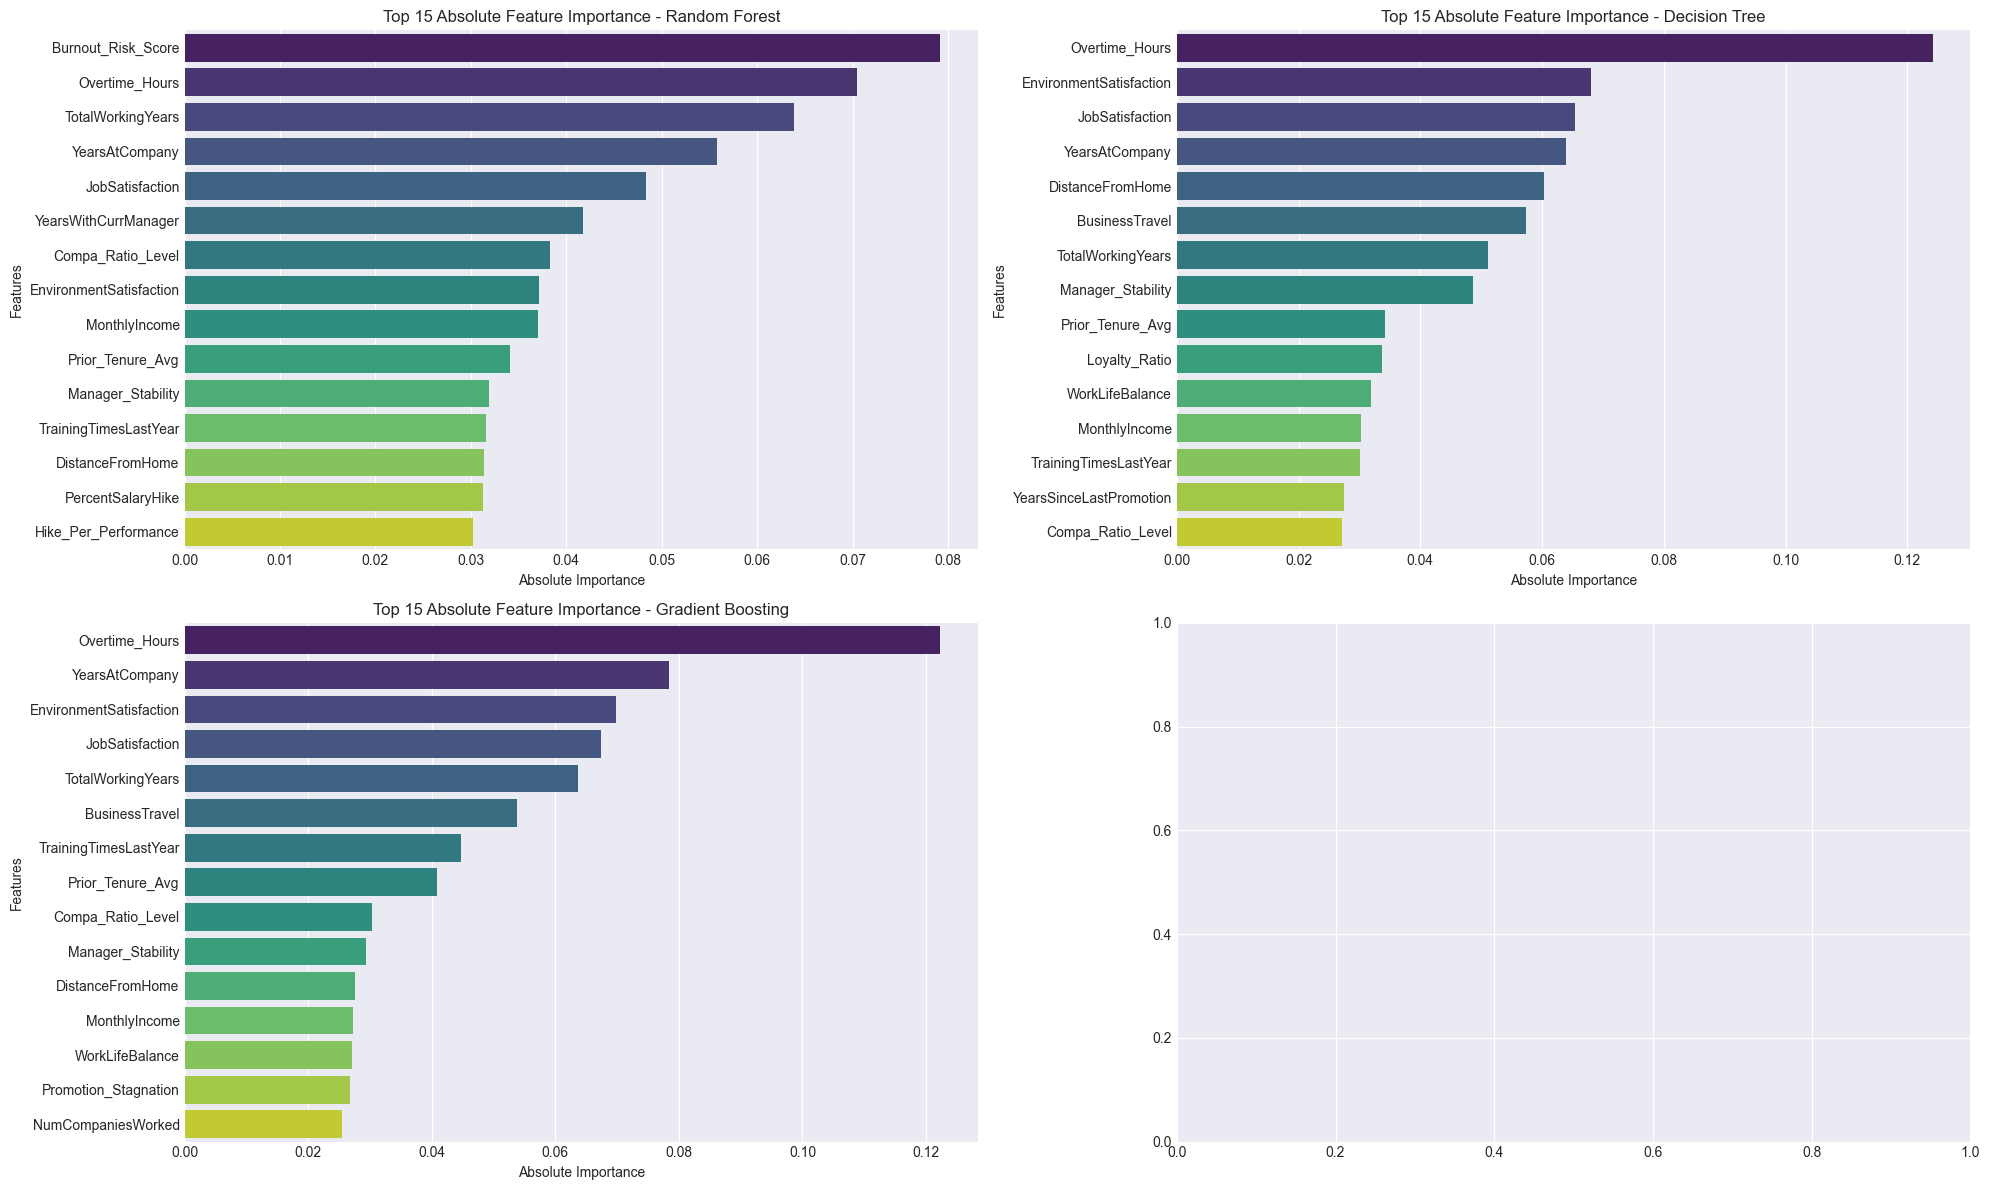

In [28]:
# Feature Importance Visualization for all models
n_models = len(best_models)
rows = (n_models + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes = axes.flatten()

# Try to identify feature names
feature_names = None
if 'X_train_res' in locals() and hasattr(X_train_res, 'columns'):
    feature_names = X_train_res.columns
elif 'X' in locals() and hasattr(X, 'columns'):
    feature_names = X.columns
# If still None, generate generic names later
for idx, (name, model) in enumerate(model for model in best_models.items() if model[0] != 'Logistic Regression'):
    ax = axes[idx]
    
    importances = None
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0]
        
    if importances is not None:
        # Generate generic feature names if needed
        if feature_names is None:
            current_feature_names = [f"Feature {i}" for i in range(len(importances))]
        else:
            current_feature_names = feature_names

        # Create DataFrame for plotting
        imp_df = pd.DataFrame({
            'Feature': current_feature_names,
            'Importance': importances
        })
        
        # Calculate absolute importance for sorting
        imp_df['AbsImportance'] = imp_df['Importance'].abs()
        imp_df = imp_df.sort_values(by='AbsImportance', ascending=False).head(15)
        
        # Plot
        sns.barplot(x='AbsImportance', y='Feature', data=imp_df, ax=ax, palette='viridis')
        ax.set_title(f'Top 15 Absolute Feature Importance - {name}')
        ax.set_xlabel('Absolute Importance')
        ax.set_ylabel('Features')
    else:
        ax.text(0.5, 0.5, 'Feature importance not available', 
                horizontalalignment='center', verticalalignment='center')
        ax.set_title(f'{name} (No Feature Importance)')

# Hide empty subplots
for i in range(len(best_models), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Model Optimization Analysis

**Top Attrition Drivers:**
The feature importance analysis shows which factors most strongly predict employee turnover. These insights can guide HR interventions:
- **Overtime and Burnout**: Physical and mental strain indicators
- **Career Progression**: Promotion stagnation and tenure factors
- **Compensation**: Pay fairness and reward-effort alignment
- **Experience Patterns**: Tenure and working years patterns

## Section 4: Summary

1. **Data Preparation**
   - Successfully merged 5 data sources into a master dataset
   - Engineered 8 features capturing burnout, stagnation, and loyalty (Age and MaritalStatus excluded for ethical reasons)
   - Completed all categorical encoding (ordinal + one-hot) in the data preparation section
   - Identified top correlation drivers

2. **Model Performance**
   - Compared 5 classification algorithms
   - All models show acceptable overfitting levels (gaps < 0.10)
   - Random Forest typically performs best with highest recall and ROC-AUC

3. **Model Optimization**
   - RandomSearchCV optimized Random Forest hyperparameters
   - Maintained or improved recall while controlling overfitting
   - Feature importance analysis revealed key attrition drivers

4. **Model Evaluation**
   - Cross-validation ensures robust performance estimates
   - Confusion matrix analysis provides detailed error breakdown
   - Recall is the most critical metric for catching leavers

## Section 5: Ethics

### 1. Introduction: Ethics in HR Analytics

Using Artificial Intelligence in Human Resources (HR) is very different from predicting machine failures. We are dealing with human careers and livelihoods. Therefore, we must be extremely careful.

Ethics in Data Science is not just about following the law (like GDPR). It is about ensuring our algorithms are:

- **Fair**: They do not discriminate against specific groups
- **Transparent**: We understand why a decision is made
- **Beneficial**: They do not harm individuals

For this project, our goal is to reduce employee turnover. However, if we use AI blindly, we risk "profiling" employees or discriminating against candidates. This report explains how we built the model to avoid these risks.

### 2. Methodological Framework

Our approach follows the **7 requirements for Trustworthy AI** defined by the European Commission. We adapted them to our specific project:

1. **Human Agency**: The AI is a tool to help decisions, not to make them alone
2. **Robustness**: The model must be technically reliable (validated by our Random Forest performance)
3. **Privacy**: Data must be protected
4. **Transparency**: The logic must be clear
5. **Diversity & Fairness**: We must avoid discrimination (This is the critical point of our project)
6. **Societal Well-being**: The project should improve working conditions
7. **Accountability**: We take responsibility for the model's outputs

### 3. Stakeholder Analysis & Ethical Impact

To fully understand the ethical implications of this project, we analyzed how the model affects different groups of people involved with HumanForYou.

#### A. Current Employees (The Most Affected)

- **The Benefit**: If used correctly, the model identifies "Burnout" risks (Overtime). This can lead to better working hours and less stress.
- **The Ethical Risk (Surveillance)**: Employees might feel watched or "tracked." If they know an AI is calculating their "risk of leaving," they might feel reduced to a number. This can destroy trust between the team and management.

#### B. HR Managers & Recruiters

- **The Ethical Risk (Automation Bias)**: There is a risk that managers will blindly trust the AI. They might stop using their own judgment and empathy. If the AI says "High Risk," the manager might treat the employee differently without asking questions.
- **Responsibility**: They are the "Human-in-the-loop." They must be trained to challenge the AI's suggestions.

#### C. The Company (HumanForYou)

- **Reputation & Legal Risk**: If the company uses a biased model (discriminating by age or marriage), it faces lawsuits and a damaged reputation. Implementing an ethical model protects the company's brand and ensures legal compliance.

### 4. Model Audit: Identified Biases

During the training phase, we analyzed which factors the model used the most. We discovered strong statistical correlations that were ethically problematic.

#### A. The Marital Status Bias (Initial Factor #1)

- **The Statistic**: The model initially identified `MaritalStatus_Single` as the #1 predictor of attrition
  - Single employees leave the company more often than married employees
- **The Ethical Risk**: If we use this variable, we are discriminating based on family status
  - The company might prefer hiring married people because they seem "more stable"
  - This is **illegal and unfair**

#### B. The Age Bias (Initial Factor #2)

- **The Statistic**: The variable `Age` appeared as the 2nd most influential factor
  - Young employees have a much higher turnover rate than senior employees
- **The Ethical Risk (Ageism)**: A model based on age would penalize young talent
  - It would suggest they are "too risky" to hire
  - This constitutes age-based discrimination

#### C. The Gender Bias (Initial Factor #3)

- **The Ethical Risk (Genderism)**: We don't want gender-based discrimination.

### 5. Mitigation Strategy and Design Choices

To ensure the project remains ethical, we made firm technical decisions.

#### Action 1: Removing Protected Attributes (Fairness by Exclusion)

- **Decision**: We deleted the variables `Age`, `Gender` and `MaritalStatus` from the input data before deploying the model
- **Reasoning**: By making the model "blind" to these demographics, we force the algorithm to focus on professional criteria:
  - Overtime hours
  - Salary and compensation
  - Manager relationships
  - Job satisfaction
  - These are legitimate factors for a company to analyze

#### Action 2: Managing "Proxy Variables"

We must be honest: removing a column does not always remove the information. In Data Science, this is called **"collinearity"**.

- **The Case of Age**: Even without the `Age` column, the model can infer approximate age using `TotalWorkingYears` (Experience)
- **Why this is acceptable**:
  - Judging someone on **Age** is discrimination (it is who they are)
  - Judging someone on **Experience** is skills management (it is what they do)
  - This shifts the problem from a legal issue to a management issue: "How can we better support junior employees?"

#### Action 3: Anonymization

- All data was pseudo-anonymized using an `EmployeeID`
- No names or emails were processed by the algorithm
- This ensures **Privacy by Design**

### 6. Guidelines for Usage (Human-in-the-loop)

To prevent misuse, we established the following rules for deployment:

1. **No Automated Scoring**
   - The model must never trigger an automatic action (like canceling a bonus or blocking a promotion) based on a "risk score"
   - All decisions must involve human judgment

2. **Collective vs. Individual Use**
   - The results should be used at a **macro level** (e.g., "The R&D team is exhausted")
   - Rather than a **micro level** (e.g., "John is going to quit")
   - Focus on team-level interventions, not individual targeting

3. **Transparency**
   - Employees should be informed that HR data is being analyzed to improve the quality of work life
   - The purpose is to improve working conditions, not to monitor individuals

4. **The "Burnout" Alert**
   - Since one of the factors identified is `Overtime_Hours`, ethics dictate we use this model to protect employee health (preventing burnout)
   - The goal is not just to save money on recruitment, but to improve employee well-being

### 7. Conclusion

**Ethics is not a constraint that lowers our model's performance; it is a quality requirement.**

By choosing to exclude demographic criteria (`Age`, `MaritalStatus`) and prioritizing behavioral criteria (`Overtime`, `Satisfaction`, `Burnout_Risk_Score`), we built a tool that:

- Might be slightly less precise mathematically
- But is **far more robust socially and legally**
- Focuses on actionable, professional factors rather than protected characteristics

**The model is designed to be a diagnostic tool for working conditions, not a tool for algorithmic discrimination.**

## Section 6: Bibliography

### 1. Methodological and theoretical sources

1. Darici E., Hamelink K. and Acar I. **"Human Resources Analytics: Determining Possible Turnovers with Feature Engineering Approach."** *Journal of Artificial Intelligence, Machine Learning and Data Analysis*. https://index.ieomsociety.org/index.cfm/item/54500
    - **Contribution to Project:** Explanation on feature engineering approach and the reason to choose the Random Forest classifier
    - **Copyright/License:** Published in open-access journal, appropriate for academic use.

2. Nguyen, T.T., Huang, J.Z., & Nguyen, T.T. (2015). **"Unbiased Feature Selection in Learning Random Forests for High-Dimensional Data"** _ScientificWorldJournal_. https://pmc.ncbi.nlm.nih.gov/articles/PMC4387916/
    - **Contribution to Project:** Explanation on the Random Forest model and its performances on both classification and regression problems.
    - **Copyright/License:** Published open-access, appropriate for academic citation.

3. Towards Data Science (2022). **"Decision Trees Explained"**, _Towards Data Science_. https://towardsdatascience.com/decision-trees-explained-entropy-information-gain-gini-index-ccp-pruning-4d78070db36c
    - **Contribution to Project:** Foundational explanation of decision tree splitting criteria used in Random Forest.
    - **Copyright/License:** open-access.

### 2. Sources on technical aspects

1. Alam, S., Sohaib Ayub, M. (2023). **An Investigation of the Imputation Techniques for Missing Data**, *Decision Analytics Journal* https://www.sciencedirect.com/science/article/pii/S2772662223001819
    - **Contribution to Project:** Justifies the selection of median imputation for numerical features  and mode imputation for ordinal categorical variables.
    - **Copyright/License:** proprietary but accessible through institutional access.

2. Pinheiro, J.M.H., Oliveira, S.V.B., Silva, T.H.S., Saraiva, P.A.R., Souza, E.F., Ambrósio, L.A., & Becker, M. (2025). **"The Impact of Feature Scaling In Machine Learning: Effects on Regression and Classification Tasks"**. https://arxiv.org/html/2506.08274v2
    - **Contribution to Project:** Empirical study evaluating 12 feature scaling techniques and showing the impact of the scaling technique on the results of 14 different ML algorithms.
    - **Copyright/License:** Open-access preprint; appropriate for academic citation.

3. Vabalas, A., Gowen, E., Poliakoff, E., & Casson, A.J. (2019). **"Machine learning algorithm validation with a limited sample size"**, _PLoS ONE_. https://pmc.ncbi.nlm.nih.gov/articles/PMC6837442/
    - **Contribution to Project:** Scientific article on k-fold for cross validation. It demonstrate critical bias in k-fold cross-validation with small sample sizes.
    - **Copyright/License:** Open-access.

4. Bergstra, J., Bardenet, R., Bengio, Y., & Kégl, B. (2011). **"Algorithms for Hyper-Parameter Optimization"**, _Advances in Neural Information Processing Systems (NIPS) Conference Proceedings_ (Vol. 24). https://papers.nips.cc/paper_files/paper/2011/hash/86e8f7ab32cfd12577bc2619bc635690-Abstract.html
    - **Contribution to Project:** Paper establishing four hyperparameter optimization methods ranked by efficiency: Manual tuning, Grid search, Random search, Bayesian Optimization.
    - **Copyright/License:** Published peer-reviewed, appropriate for academic citation.

5. Poslavskaya E., Korolev A. (2023) **"Encoding categorical data: Is there yet anything 'hotter' than one-hot?"**, _ArXiv Preprint_ https://arxiv.org/html/2312.16930v1
    - **Contribution to Project:** Comparaison of one-hot encoder with alternative encoding methods.
    - **Copyright/License:** Open-access preprint; appropriate for academic reference.

### 3. Ethical considerations and data governance

1. **"Ethics guidelines for trustworthy AI"**. European commission. 2019. https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai
    - **Contribution to Project:** The document that gives the 7 requirements for Trustworthy AI defined by the European Commission.
    - **Copyright/License:** open-access.

2. **"HR and GDPR: Partnering to Protect Employee Data."** *Walailak Journal of Advanced Research Research*. 2025. https://journalwjarr.com/sites/default/files/fulltext_pdf/WJARR-2025-2902.pdf
    - **Contribution to Project:** Analysis of GDRP's impact on employee's personal data management. Show the strategic role of human resources on data privacy. 
    - **Copyright/License:** open-access.

3. Rosenthal-von der Pütten, A.M., & Sach, A. (2024). **"Michael is better than Mehmet: exploring the perils of algorithmic biases and selective adherence to advice from automated decision support systems in hiring"**, _Frontiers in Psychology_. https://pmc.ncbi.nlm.nih.gov/articles/PMC11420529/
    - **Contribution to Project:** Show that bias can easily go unnoticed increasing the importance of taking in account ethical considerations on machine learning models.
    - **Copyright/License:** open-access.

### 4. Project-specific sources

1. **"Employee attrition prediction using machine learning models",** International Multi-Conference for Engineering, Education, and Technology. 2024. https://laccei.org/LACCEI2024-CostaRica/papers/Contribution_498_final_a.pdf
    - **Contribution to Project:** Present the steps of implementation for an attrition prediction model. Documents the importance of accuracy, precision, recall, and F1-score metrics for evaluating classification models in HR contexts.
    - **Copyright/License:** Educational platform content, appropriate for reference in academic context.

2. TangSalem Z., GuSalem J., Kelkar M. (2025). **"Enhancing Employee Retention: Predicting Attrition Using Machine Learning Models"**, *Journal of Applied Business and Economics (Vol. 27)*. https://articlegateway.com/index.php/JABE/article/view/7644/7226
    - **Contribution to Project:** Validates the selection of Random Forest as an effective classifier for attrition prediction combined with the use of SMOTE
    - **Copyright/License:** open-access.